In [160]:
import numpy as np
import csv
import datetime
import timedelta
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [161]:
file = open("../Simplified_Dataset.csv")
csvreader = csv.reader(file)
rows = []
header = next(csvreader)
for row in csvreader:
    rows.append(row)
file.close()

(1311,)

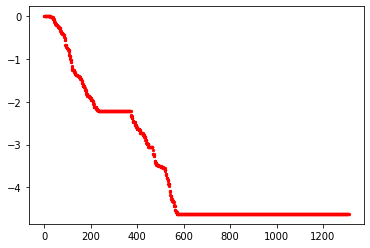

In [162]:
def add_minutes(Time, period):
    res = Time + datetime.timedelta(minutes = period)
    return res

account = input()
sum = 0.0
start_time = datetime.datetime.strptime("2020-10-04 14:30:00", "%Y-%m-%d %H:%M:%S")
end_time = datetime.datetime.strptime("2020-10-05 12:20:00", "%Y-%m-%d %H:%M:%S")
period = 1
Time = start_time
sum = 0
index = 0
x = []
y = []

while Time <= end_time:
    x.append(index)
    Time = add_minutes(Time, period)
    index = index + 1

Time = start_time

for row in rows:
    str = row[4]
    str = str.removesuffix(" +UTC")
    cur_time = datetime.datetime.strptime(str, "%b-%d-%Y %I:%M:%S %p")
    while Time <= cur_time:
        y.append(sum)
        Time = add_minutes(Time, period)

    if row[1] == account:
        sum = sum - float(row[3])
    if row[2] == account:
        sum = sum + float(row[3])

while Time <= end_time:
    y.append(sum)
    Time = add_minutes(Time, period)

x = np.array(x)
y = np.array(y)

plt.scatter(x, y, s = 5, color = 'red')

x.shape


In [163]:
def modify_for_lstm(Data, period):
    N = Data.shape[0]
    res_x = [[Data[i + j] for i in range(period)] for j in range(N - period)]
    res_y = [Data[i + period] for i in range(N - period)]
    return res_x, res_y

steps = 50

X, Y = modify_for_lstm(y, steps)

X = np.array(X)
Y = np.array(Y)

N = Y.shape[0]
X.shape

(1261, 50)

In [164]:
train_size = int(X.shape[0] * 0.35)
test_end = int(X.shape[0] * 0.5)

x_train = X[:train_size]
x_test = X[train_size:test_end]
y_train = Y[:train_size]
y_test = Y[train_size:test_end]

scalerX = StandardScaler()
x_train_scale = scalerX.fit_transform(x_train)
x_test_scale = scalerX.fit_transform(x_test)

scalerY = StandardScaler()

y_train = np.array(y_train).reshape(-1, 1)
y_test = np.array(y_test).reshape(-1, 1)

y_train_scale = scalerY.fit_transform(y_train)
y_test_scale = scalerY.fit_transform(y_test)

In [165]:
model = Sequential()

model.add(LSTM((1), batch_input_shape = (None, steps, 1), return_sequences = True))
model.add(LSTM((1), return_sequences = False))
model.add(Dense(1))

model.compile(loss = 'mean_absolute_error', optimizer = 'adam', metrics = ['accuracy'])

model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 50, 1)             12        
                                                                 
 lstm_33 (LSTM)              (None, 1)                 12        
                                                                 
 dense_4 (Dense)             (None, 1)                 2         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [166]:
history = model.fit(x_train_scale, y_train_scale, epochs = 400, validation_data = (x_test_scale, y_test_scale))

Epoch 1/400
14/14 [==============================] - 14s 256ms/step - loss: 0.9838 - accuracy: 0.0000e+00 - val_loss: 1.0974 - val_accuracy: 0.0000e+00
Epoch 2/400
14/14 [==============================] - 1s 51ms/step - loss: 0.9599 - accuracy: 0.0000e+00 - val_loss: 1.0725 - val_accuracy: 0.0000e+00
Epoch 3/400
14/14 [==============================] - 1s 51ms/step - loss: 0.9394 - accuracy: 0.0000e+00 - val_loss: 1.0490 - val_accuracy: 0.0000e+00
Epoch 4/400
14/14 [==============================] - 1s 50ms/step - loss: 0.9206 - accuracy: 0.0000e+00 - val_loss: 1.0273 - val_accuracy: 0.0000e+00
Epoch 5/400
14/14 [==============================] - 1s 49ms/step - loss: 0.9025 - accuracy: 0.0000e+00 - val_loss: 1.0078 - val_accuracy: 0.0000e+00
Epoch 6/400
14/14 [==============================] - 1s 50ms/step - loss: 0.8865 - accuracy: 0.0000e+00 - val_loss: 0.9888 - val_accuracy: 0.0000e+00
Epoch 7/400
14/14 [==============================] - 1s 51ms/step - loss: 0.8713 - accuracy: 0.000

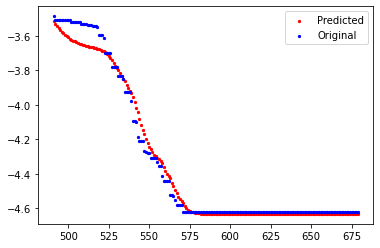

In [167]:
results_scaled = model.predict(x_test_scale)
results = scalerY.inverse_transform(results_scaled)
# test_size = x_test.shape[0]

plt.scatter(range(train_size + steps, test_end + steps), results, s = 5, color = 'red', label = 'Predicted')
plt.scatter(range(train_size + steps, test_end + steps), y_test, s = 5, color = 'blue', label = 'Original')
plt.legend()
plt.show()

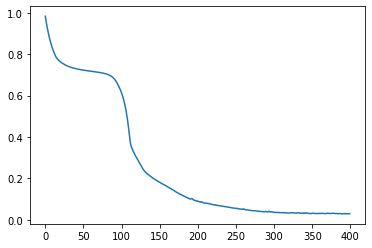

In [168]:
plt.plot(history.history['loss'])
plt.show()

In [169]:
print('R2 Score: ', r2_score(y_test_scale, results_scaled))
print('MAE: ', mean_absolute_error(y_test_scale, results_scaled))
print('MSE: ', mean_squared_error(y_test_scale, results_scaled))

R2 Score:  0.9848218399774679
MAE:  0.08159653115531985
MSE:  0.01517816002253211
